In [1]:
import mne
import os
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA


from aux_func import *
from class_functions import *

# Explicação

Esse segundo Script realiza a etapa de pré-processamento. São aplicados PCA, ICA e CCA (separadamente) e, no final do Script, é criado uma janela temporal.

In [14]:
### Input de dados

run_me = 1
sub = 8

df = pd.read_parquet(f"../DATA_TIDY/subject {sub}/data{sub}pp_{run_me}.parquet")


### Essa variável é utilizada caso queira criar os objetos de PCA, ICA e CCA.
### Caso só queira aplicar o pré-processamento já treinado, deixar 'False'.
analysis = True

### Pega os dados
X_raw = df.drop('Classe', axis=1).values
y = df.Classe.values

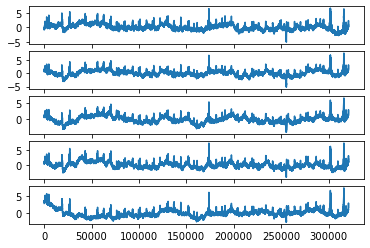

In [15]:
### Plota os 5 primeiros sinais
nrows = 5
fig, ax = plt.subplots(nrows=nrows)
time = df.index
for i in range(nrows):
    ax[i].plot(time, X_raw[:,i])
plt.show()

# EEG Pre-processing

## Filtering

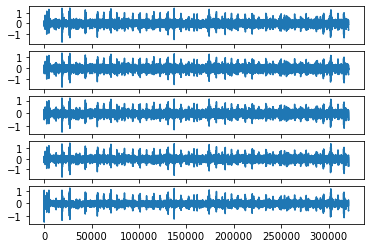

In [16]:
### Essa célula filtra os dados e printa os 5 primeiros sinais.
### Para mudar o número de sinais, mude a variável 'nrows'

filter_list = []
for i in range(X_raw.shape[1]):
    # A função butter_bandpassa_filter aplica o filtro. Recebe 3
    # parâmetros, frequência de corte 1, frequência de corte 2
    # (passa-faixa) e a frequência de amostragem.
    filter_list.append(butter_bandpass_filter(X_raw[:,i], 4, 25, 256).reshape(-1,1))
X_filter = np.concatenate(filter_list, axis=1)

nrows = 5
fig, ax = plt.subplots(nrows=nrows)
time = df.index
for i in range(nrows):
    ax[i].plot(time, X_filter[:,i])
plt.show()

X = X_filter.copy()

### Aqui cria a pasta do sujeito do estudo. Pode remover se necessário
if not os.path.isdir(f"../TRAINED/subject {sub}"):
    os.mkdir(f"../TRAINED/subject {sub}")

## PCA

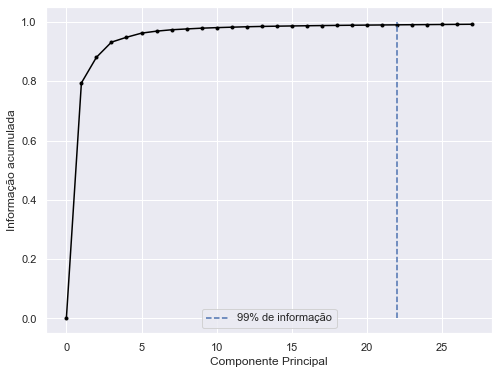

22


In [19]:
### Essa célula aplica o PCA nos dados e salva no diretório 'pca_file'.
### Caso 'analysis' seja 'True', ele cria o PCA com a informação desejada
### (regulada pela variável 'info'). Caso seja 'False', ele abre o arquivo
### e aplica no conjunto de dados, sem treinar o PCA novamente.

pca_file = f"../TRAINED/subject {sub}/pca_obj.pkl"

if analysis: 
    
    info = 0.99
    evr = PCA().fit(X).explained_variance_ratio_
    for i in range(1,len(evr)):
        if evr[:i].sum() > info:
            break
    
    pca = PCA(n_components=i).fit(X)
    
    with open(pca_file, "wb") as f:
        pickle.dump(pca, f)

        
else:
    with open(pca_file, "rb") as f:
        pca = pickle.load(f)

X_pca = pca.transform(X)


### Aqui ele gera um plot sobre a variância de cada componente.
if analysis:
    import seaborn as sns
    sns.set()
    evrc = evr[:5+i]
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(evrc)+1), np.cumsum([0] + list(evrc)), c='black', marker='.')
    plt.plot([i,i],[0,1],linestyle='--', label=f'{round(info*100)}% de informação')
    plt.xlabel("Componente Principal")
    plt.ylabel("Informação acumulada")
    plt.legend(loc=0)
    plt.show()
    
    print(i)

## ICA

In [10]:
### Essa célula aplica o ICA nos dados e salva no diretório 'ica_file'.
### Caso 'analysis' seja 'True', ele cria o ICA. Caso seja 'False', 
### ele abre o arquivo e aplica no conjunto de dados, sem treinar.

ica_file = f"../TRAINED/subject {sub}/ica_obj.pkl"

if analysis: 
    ica = ICA(max_iter=2000).fit(X)
    
    with open(ica_file, "wb") as f:
        pickle.dump(ica, f)

    
else:
    with open(ica_file, "rb") as f:
        ica = pickle.load(f)

X_ica = ica.transform(X)

## SOM

In [24]:
### Aqui cria o objeto SOM para alimentar o CCA. O mapa
### nesse script é quadrado, mas o usuário pode mudar isso,
### só modificar a variável 'shape'. Esse objeto fica salvo
### no diretório 'som_file'. Caso 'analysis' seja 'True', 
### ele cria o SOM. Caso contrário, só abre.

l = 20
shape = (l,l)
som = SOMDL(shape, X.shape[1], 35)

som_file = f"../TRAINED/subject {sub}/map.parquet"

if analysis: 
    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    som.saveSOM(som_file)
    
else:
    som.loadSOM(som_file)

Progress: 100.00% 


### CCA

In [12]:
### Aqui temos o CCA. Inicialmente, ele pega os centros do SOM.
### Aparece uma nova variável aqui, 'search_cca'. Para encontrar
### a dimensão final do CCA, Hérault et. al (1999) desenvolveram
### uma metodologia: crie o CCA com dimensão grande e vá diminuindo.
### Quando os pontos deixarem de ficar na diagonal principal (dy-dx), 
### você chegou na dimensão certa. Depois, teste diferentes parâmetros 
### de 'lambda'. Aquele que possuir pontos abaixo da bissetriz (dy-dx)
### para valores médios de dy, é o melhor lambda.
###
### O 'elif' abaixo realiza essa procura, onde o 'p' representa as
### dimensões que serão testadas e 'l' os valores de lambda. Minha
### recomendação: primeiro deixe 'l' constante (e um valor bem grande)
### até achar a dimensão, depois deixe 'p' constante e varie 'l'.

centers = som.map.reshape(-1,som.m)

search_cca = False

if analysis and not search_cca:
    cca = CCA(3, 6.7, 0.1)
    centers_cca = cca.run(centers, q_max=1000,tol=1e-6, init='Random')
    if analysis:
        cca.plotYX()

    cca_file = f"../TRAINED/subject {sub}/cca_centers.pkl"

    with open(cca_file, "wb") as f:
        pickle.dump(centers_cca,f)
        
elif analysis and search_cca:
    for p in range(3,4):
        for l in [6,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9]:
            print(p,l)
            cca = CCA(p, l, 0.1)
            cca.run(centers, q_max=1000,tol=1e-6, init='Random')
            cca.plotYX()
            
else:
    cca_file = f"../TRAINED/subject {sub}/cca_centers.pkl"

    with open(cca_file, "rb") as f:
        centers_cca = pickle.load(f)

    idx = np.apply_along_axis(lambda x: cdist(x.reshape(1,-1), centers).argmin(), 1, X)
    X_cca = centers_cca[idx]

# Creating Data

In [148]:
### Gerando janela temporal (w determina o número de sinais)
W_cca, y_w = createXY(X_cca, y, w=10)
W_ica, _ = createXY(X_ica, y, w=10)
W_pca, _ = createXY(X_pca, y, w=10)


### Gerando dataframe de cada sinal
cca_df = pd.DataFrame(W_cca)
cca_df.columns = list(map(lambda c: f"CCA_{c}", np.arange(W_cca.shape[1])))

ica_df = pd.DataFrame(W_ica)
ica_df.columns = list(map(lambda c: f"ICA_{c}", np.arange(W_ica.shape[1])))

pca_df = pd.DataFrame(W_pca)
pca_df.columns = list(map(lambda c: f"PCA_{c}", np.arange(W_pca.shape[1])))

signal_df = pd.concat([cca_df, ica_df, pca_df], axis=1)
signal_df["y"] = y_w


### Salvando os resultados
signal_df.astype(np.float32).to_parquet(f"../DATA_TIDY/subject {sub}/signal_{sub}_{run_me}.parquet")

## SOM Analysis

Aqui, se compara 2 tipos de algoritmo SOM. SOM-DL se comporta melhor em sinais com 'eventos' menos frequentes.

In [93]:
run_analysis = False

In [94]:
if run_analysis:
    l_list = [15,20,25,30,35]
    mse_list_c = []
    for l in l_list:
        shape = (l,l)
        som = SOM(shape, 61, 20)

        runs = 1000 + 500*shape[0]*shape[1]
        for i in range(runs):
            print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
            n = np.random.randint(X.shape[0])
            sample = X[n,:]
            som.run(sample)
        print("Progress: 100.00% ")

        npoints = 5000

        list_som = []
        for i in range(npoints):
            sample = X[i+100,:]
            cd = som.activate(sample)
            list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

        array_som = np.concatenate(list_som, axis=0)
        mse = np.mean(np.linalg.norm(X[100:100 + npoints] - array_som, axis=1))
        mse_list_c.append(mse)

In [95]:
if run_analysis:
    l_list = [15,20,25,30,35]
    mse_list_d = []
    for l in l_list:
        shape = (l,l)
        som = SOMDL(shape, 61, 20, 0.2)

        runs = 1000 + 500*shape[0]*shape[1]
        for i in range(runs):
            print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
            n = np.random.randint(X.shape[0])
            sample = X[n,:]
            som.run(sample)
        print("Progress: 100.00% ")

        npoints = 5000

        list_som = []
        for i in range(npoints):
            sample = X[i+100,:]
            cd = som.activate(sample)
            list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

        array_som = np.concatenate(list_som, axis=0)
        mse = np.mean(np.linalg.norm(X[100:100 + npoints] - array_som, axis=1))
        mse_list_d.append(mse)

In [96]:
if run_analysis:
    plt.plot(list(map(lambda x: x**2, l_list)), mse_list_c, marker='^', label='SOM Clássic', c='orange')
    plt.plot(list(map(lambda x: x**2, l_list)), mse_list_d, marker='*', label='SOM-DL', c='purple')
    plt.title("MSE - SOM 'Clássico' vs SOM-DL")
    plt.xlabel("Número de Neurônios no Mapa")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

#### Comparing classic SOM and SOM-DL

Progress: 100.00% 


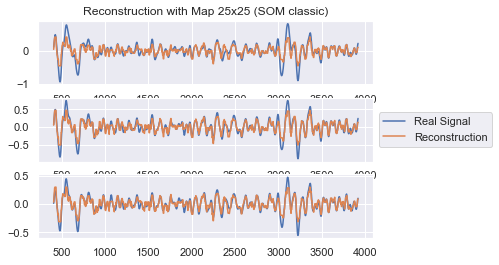

MSE of Reconstruction with Map 25x25 (SOM classic): 0.66


In [26]:
if run_analysis:
    l = 25
    shape = (l,l)
    som = SOM(shape, 61, 20)

    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    nrows = 3

    npoints = 1000

    list_som = []
    for i in range(npoints):
        sample = X[i,:]
        cd = som.activate(sample)
        list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

    array_som = np.concatenate(list_som, axis=0)


    fig, ax = plt.subplots(nrows=nrows, figsize=(8,8))
    time = df.index
    for i in range(nrows):
        ax[i].plot(time[100:npoints], X[100:npoints,i], label='Real Signal')
        ax[i].plot(time[100:npoints], array_som[100:npoints,i], label="Reconstruction")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title("Reconstruction with Map 25x25 (SOM classic)")
    ax[1].set_xlabel("Time (ms)")
    plt.show()

    mse = np.mean(np.linalg.norm(X[100:npoints] - array_som[100:npoints], axis=1))
    print(f"MSE of Reconstruction with Map 25x25 (SOM classic): {round(mse,2)}")

Progress: 100.00% 


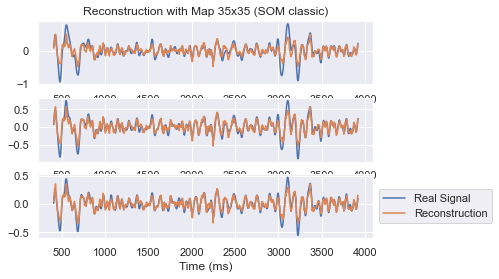

MSE of Reconstruction with Map 35x35 (SOM classic): 0.63


In [22]:
if run_analysis:
    l = 35
    shape = (l,l)
    som = SOM(shape, 61, 20)

    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    nrows = 3

    npoints = 1000

    list_som = []
    for i in range(npoints):
        sample = X[i,:]
        cd = som.activate(sample)
        list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

    array_som = np.concatenate(list_som, axis=0)


    fig, ax = plt.subplots(nrows=nrows)
    time = df.index
    for i in range(nrows):
        ax[i].plot(time[100:npoints], X[100:npoints,i], label='Real Signal')
        ax[i].plot(time[100:npoints], array_som[100:npoints,i], label="Reconstruction")
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title("Reconstruction with Map 35x35 (SOM classic)")
    plt.xlabel("Time (ms)")
    plt.show()

    mse = np.mean(np.linalg.norm(X[100:npoints] - array_som[100:npoints], axis=1))
    print(f"MSE of Reconstruction with Map 35x35 (SOM classic): {round(mse,2)}")

Progress: 100.00% 


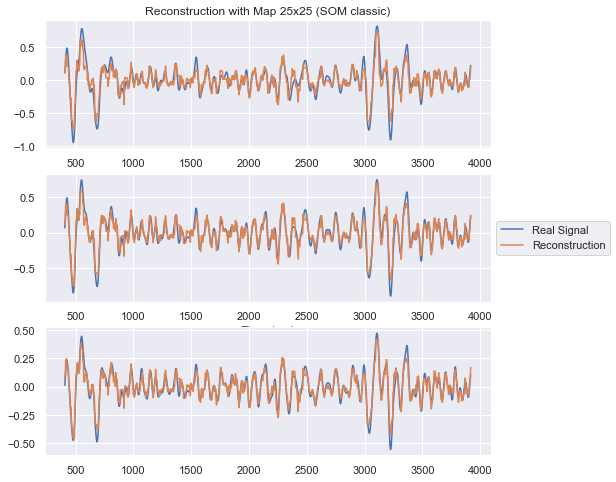

MSE of Reconstruction with Map 25x25 (SOM classic): 0.57


In [30]:
if run_analysis:
    l = 25
    shape = (l,l)
    som = SOMDL(shape, 61, 20, 0.2)

    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    nrows = 3

    npoints = 1000

    list_som = []
    for i in range(npoints):
        sample = X[i,:]
        cd = som.activate(sample)
        list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

    array_som = np.concatenate(list_som, axis=0)


    fig, ax = plt.subplots(nrows=nrows, figsize=(8,8))
    time = df.index
    for i in range(nrows):
        ax[i].plot(time[100:npoints], X[100:npoints,i], label='Real Signal')
        ax[i].plot(time[100:npoints], array_som[100:npoints,i], label="Reconstruction")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title("Reconstruction with Map 25x25 (SOM-DL)")
    ax[1].set_xlabel("Time (ms)")
    plt.show()

    mse = np.mean(np.linalg.norm(X[100:npoints] - array_som[100:npoints], axis=1))
    print(f"MSE of Reconstruction with Map 25x25 (SOM-DL): {round(mse,2)}")

Progress: 100.00% 


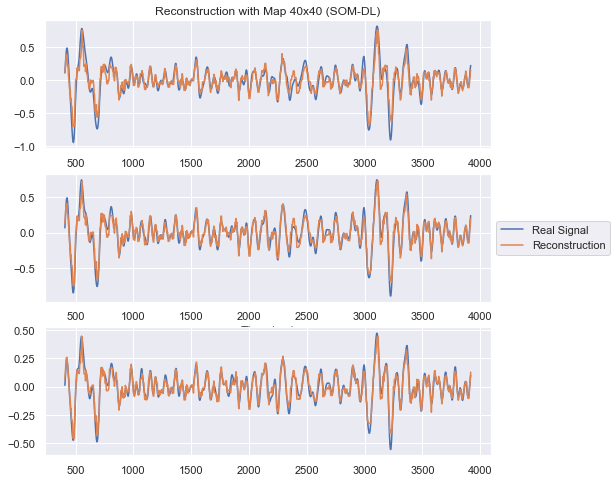

MSE of Reconstruction with Map 40x40 (SOM-DL): 0.52


In [32]:
if run_analysis:
    l = 40
    shape = (l,l)
    som = SOMDL(shape, 61, 20, 0.2)

    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    nrows = 3

    npoints = 1000

    list_som = []
    for i in range(npoints):
        sample = X[i,:]
        cd = som.activate(sample)
        list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

    array_som = np.concatenate(list_som, axis=0)


    fig, ax = plt.subplots(nrows=nrows, figsize=(8,8))
    time = df.index
    for i in range(nrows):
        ax[i].plot(time[100:npoints], X[100:npoints,i], label='Real Signal')
        ax[i].plot(time[100:npoints], array_som[100:npoints,i], label="Reconstruction")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title("Reconstruction with Map 40x40 (SOM-DL)")
    ax[1].set_xlabel("Time (ms)")
    plt.show()

    mse = np.mean(np.linalg.norm(X[100:npoints] - array_som[100:npoints], axis=1))
    print(f"MSE of Reconstruction with Map 40x40 (SOM-DL): {round(mse,2)}")

Progress: 100.00% 


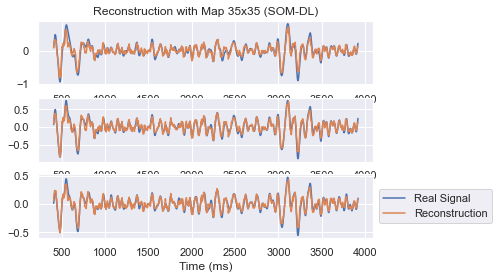

MSE of Reconstruction with Map 35x35 (SOM-DL): 0.53


In [24]:
if run_analysis:
    l = 35
    shape = (l,l)
    som = SOMDL(shape, 61, 20, 0.2)

    runs = 1000 + 500*shape[0]*shape[1]
    for i in range(runs):
        print(f"Progress: {round(i*100/runs,2)}%  ", end='\r')
        n = np.random.randint(X.shape[0])
        sample = X[n,:]
        som.run(sample)
    print("Progress: 100.00% ")

    nrows = 3

    npoints = 1000

    list_som = []
    for i in range(npoints):
        sample = X[i,:]
        cd = som.activate(sample)
        list_som.append(som.map[cd[0],cd[1]].reshape(1,-1))

    array_som = np.concatenate(list_som, axis=0)


    fig, ax = plt.subplots(nrows=nrows)
    time = df.index
    for i in range(nrows):
        ax[i].plot(time[100:npoints], X[100:npoints,i], label='Real Signal')
        ax[i].plot(time[100:npoints], array_som[100:npoints,i], label="Reconstruction")
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title("Reconstruction with Map 35x35 (SOM-DL)")
    plt.xlabel("Time (ms)")
    plt.show()

    mse = np.mean(np.linalg.norm(X[100:npoints] - array_som[100:npoints], axis=1))
    print(f"MSE of Reconstruction with Map 35x35 (SOM-DL): {round(mse,2)}")